# Sandbox For Learning TensorFlow

import tensorflow

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

Checking to see if tensorflow is using accelerated hardware

In [2]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


create a variable: x.

In [3]:
x = tf.constant([[1,2,3],[4,5,6]])
print(x)
print(x.shape)
print(x.dtype)

tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)
(2, 3)
<dtype: 'int32'>


In [4]:
print(x + 5)  # adding 5 to each value of x
print(x * 2)  # multiplying each value of x by 2
print(tf.concat([x, x, x], axis=1)) # concatenating the tensors together side by side
print(tf.reduce_sum(x)) # finds the sum of all of the elements in the tensor

tf.Tensor(
[[ 6  7  8]
 [ 9 10 11]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[ 2  4  6]
 [ 8 10 12]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[1 2 3 1 2 3 1 2 3]
 [4 5 6 4 5 6 4 5 6]], shape=(2, 9), dtype=int32)
tf.Tensor(21, shape=(), dtype=int32)


In [5]:
var = tf.Variable([0,0,0]) # creating a variable
var.assign([1,2,3]) # assigning values to the variable
var.assign_add([1,1,1]) # adding values to each element of the tensor and saving it

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([2, 3, 4])>

Tensorflow can apparently find the derrivatives of functions. This comes in very useful for things like gradient decent when calculating the loss and error of a model given a set of weights.

In [6]:
x = tf.Variable(1.0)

# we create a random function
def f(x):
    y = x**2 + 2*x - 5
    return y

f(x) # this will return -2 because f(1) = -2

# this will find the derrivative of a function
with tf.GradientTape() as tape:
    y = f(x)

g_x = tape.gradient(y, x)  # g(x) = dy/dx

g_x

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

Tensorflow also provides tools for optimization and saving your models once they are done training. To do this you are required to using tf.function. When making a tensorflow functions with the @tf.function it is called a graph and can be used to significantly speed up calculations and can also be exports on a system without a python installation.

In [7]:
@tf.function
def my_func(x): # this is our graph
  print('Tracing.\n')
  return tf.reduce_sum(x)

x = tf.constant([1,2,3])

my_func(x) # first call will be unoptimized and still call python methods
my_func(x) # second and subsequent calls will just use TF.

Tracing.



<tf.Tensor: shape=(), dtype=int32, numpy=6>

modules are a useful tool in tensorflow because they can allow you to save the values of your variables while training allowing you to load and save them with ease (using tf.train.Checkpoint). Additionally, you can save your variables and models which can allow you to run your model independently from your python code (using tf.saved_model).

In [8]:
class MyModule(tf.Module): # create our module
  def __init__(self, value): # constructor 
    self.weight = tf.Variable(value) 

  @tf.function # create a function
  def multiply(self, x): 
    return x * self.weight # multiply a value by the weight 

testing the module

In [9]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

saving our module

In [10]:
save_path = './saved'
tf.saved_model.save(mod, save_path) # saving our module to the path "./saved"

INFO:tensorflow:Assets written to: ./saved\assets


reloading our module is as easy as.

In [11]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([15, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([45,  6,  9])>

let try training loops

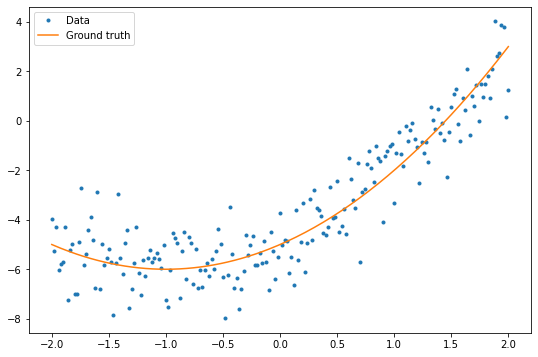

In [12]:
plt.figure(figsize=(9,6))

x = tf.linspace(-2, 2, 201) # creating a set of values from -2 to 2 with 201 values
x = tf.cast(x, tf.float32) # changing the type of the values to float32

def f(x): # creating a simple function
    y = x**2 + 2*x - 5
    return y

# adding some randomness to each point on the graph
y = f(x) + tf.random.normal(shape=[201]) # random values are based off of a normal distribution

plt.plot(x, y.numpy(), '.', label='Data') # plot each of the points of y and x
plt.plot(x, f(x),  label='Ground truth') # printing the actual values from the function and generated x values
plt.legend();



Let's create the model

In [13]:
class Model(tf.keras.Model):
    def __init__(self, units):
        super().__init__(
        )  # inherrit the functionality of the super object (tf.keras.Model).
        self.dense1 = tf.keras.layers.Dense(
            units=units,
            activation=tf.nn.relu,
            kernel_initializer=tf.random.normal,
            bias_initializer=tf.random.normal) # giving a random bias from a normal distribution
        self.dense2 = tf.keras.layers.Dense(1) # our ouput should just be one value

    # use 'call' instead of '__call__' on keras models
    def call(self, x, training=True):
        x = x[:,tf.newaxis]
        x = self.dense1(x)
        x = self.dense2(x)
        return tf.squeeze(x,axis=1)

In [14]:
model = Model(64)


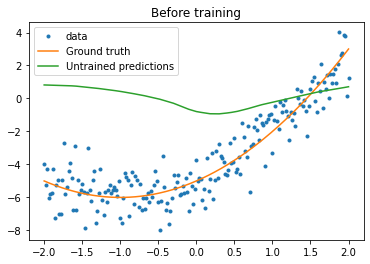

In [15]:
plt.plot(x.numpy(), y.numpy(), '.', label='data') # plot the randomly generated points
plt.plot(x, f(x),  label='Ground truth') # print what the function should actually look like
plt.plot(x, model(x), label='Untrained predictions') # these are the prediction that are made using the data
plt.title('Before training')
plt.legend();

In [16]:
variables = model.variables

optimizer = tf.optimizers.SGD(learning_rate=0.01)

for step in range(1000):
  with tf.GradientTape() as tape:
    prediction = model(x)
    error = (y-prediction)**2
    mean_error = tf.reduce_mean(error)
  gradient = tape.gradient(mean_error, variables)
  optimizer.apply_gradients(zip(gradient, variables))

  if step % 100 == 0:
    print(f'Mean squared error: {mean_error.numpy():0.3f}')

Mean squared error: 20.874
Mean squared error: 1.047
Mean squared error: 1.028
Mean squared error: 1.021
Mean squared error: 1.018
Mean squared error: 1.017
Mean squared error: 1.015
Mean squared error: 1.014
Mean squared error: 1.014
Mean squared error: 1.013


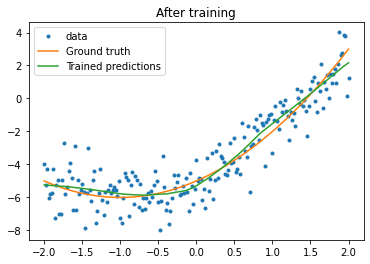

In [17]:
plt.plot(x.numpy(),y.numpy(), '.', label="data")
plt.plot(x, f(x),  label='Ground truth')
plt.plot(x, model(x), label='Trained predictions')
plt.title('After training')
plt.legend();

In [ ]:
new_model = Model(64)

In [ ]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)